In [8]:
import numpy as np
import matplotlib.pyplot as plt

In [9]:
import torch.nn as nn
import predictive_coding as pc
import numpy as np
import torch

input_size = 1
hidden_size = 128
output_size = 1
activation_fn = nn.ReLU
loss_fn = lambda output, _target: 0.5 * (output - _target).pow(2).sum() # this loss function holds to the error of the output layer of the model


model = nn.Sequential(
    nn.Linear(input_size, hidden_size),
    pc.PCLayer(),
    activation_fn(),
    nn.Linear(hidden_size, output_size)
)

In [10]:
# number of inference iterations where the latent states x are updated. Inference does not run till convergence but for a fixed number of iterations
T = 20                              

import torch.optim as optim

# options for the update of the latent state x
optimizer_x_fn = optim.SGD          # optimizer for latent state x, SGD perform gradient descent. Other alternative are Adam, RMSprop, etc. 
optimizer_x_kwargs = {'lr': 0.01}   # optimizer parameters for latent state x to pass to the optimizer. The best learning rate will depend on the task and the optimiser. 
                                    # Other parameters such as momentum, weight_decay could also be set here with additional elements, e.g., "momentum": 0.9, "weight_decay": 0.01

# options for the update of the parameters p
update_p_at = 'all'                 # update parameters p at the last iteration, can be set to 'all' to implement ipc (https://arxiv.org/abs/2212.00720)
optimizer_p_fn = optim.Adam         # optimizer for parameters p
optimizer_p_kwargs = {'lr': 0.001}  # optimizer parameters for parameters p, 0.001 is a good starting point for Adam, but it should be adjusted for the task

trainer = pc.PCTrainer(model, 
    T = T, 
    optimizer_x_fn = optimizer_x_fn,
    optimizer_x_kwargs = optimizer_x_kwargs,
    update_p_at = update_p_at,   
    optimizer_p_fn = optimizer_p_fn,
    optimizer_p_kwargs = optimizer_p_kwargs,
    plot_progress_at = [],
)

In [11]:
import torch
import torch.nn.functional as F
epochs = 2000

num_data = 10000
x_values = torch.from_numpy(np.linspace(0, 2 * np.pi, num_data)).float().unsqueeze(-1)

def f(x):
    return torch.cos(x).float()

sample_size = 256

for e in range(epochs):

    model.train()

    random_indices = torch.randperm(num_data)[:sample_size]
    x_sample = x_values[random_indices]
    y_sample = f(x_sample)

    trainer.train_on_batch(
        inputs=x_sample,
        loss_fn=loss_fn,
        loss_fn_kwargs={'_target': y_sample}
    )

    model.eval()

    pred_y = model(x_sample)
    y_values = f(x_sample)

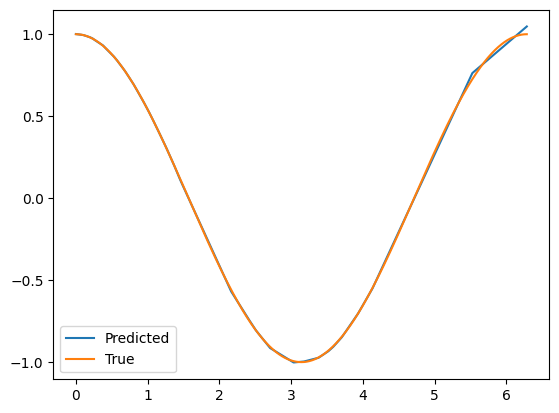

In [12]:
model.eval()

pred_y = model(x_values).detach().numpy()
y_values = f(x_values)

plt.plot(x_values, pred_y, label='Predicted')
plt.plot(x_values, y_values, label='True')
plt.legend()
plt.show()